## Training to velocities, 1st derivatives and laplacians

In [1]:
from jax_cfd.ml.diego_cnn_bcs import *

#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
from jax_cfd.ml.diego_preprocessing import *
from jax_cfd.ml.diego_train_functions import *
from jax_cfd.ml import nonlinearities

from jax_cfd.ml.newSaveObject import *
from jax_cfd.ml.diego_towers import *

import matplotlib.pyplot as plt
import seaborn

import time

In [2]:
# import data (fine grid)
# create X_data via mean pooling
# create Y_data by calculating everything for each frame and stacking them along the channel dimension

In [3]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [14]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape).T,
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape).T
    ])
    high_def.append(this_time)

In [15]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 10
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 10
Training dataset shape: 
	(864, 64, 256, 2)


In [16]:
%time high_def_norm,ogMean,ogStdDev = normalisingDataset(high_def)

CPU times: user 83 ms, sys: 9.94 ms, total: 92.9 ms
Wall time: 93.1 ms


In [17]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = creatingDataset(high_def_norm,mean_pooling,factor)

print("\nCreate Y dataset: ")
%time Y_dataset = createDatasetDerivatives(high_def_norm,sampling,factor)

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]

# NOTE: padding conditions can be specified via the "conditions" input to the padYDataset function below
# the padXDataset only pads u and v for channel flow conditions, so hard coded for impermeability and no-slip conditions (0,0)
print("\nPadding all datasets: ")
padding = [1,1] #for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
%time X_train = padXDataset(X_train,padding)
%time Y_train = padYDataset(Y_train,padding)

%time X_test = padXDataset(X_test,padding)
%time Y_test = padYDataset(Y_test,padding)

print("\nShapes of all datasets")
printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 19.5 s, sys: 6.73 ms, total: 19.5 s
Wall time: 19.6 s

Create Y dataset: 
CPU times: user 4.43 s, sys: 7.68 ms, total: 4.44 s
Wall time: 4.45 s

Padding all datasets: 
CPU times: user 13.9 s, sys: 8.12 ms, total: 13.9 s
Wall time: 13.9 s
CPU times: user 55.2 s, sys: 27.4 ms, total: 55.3 s
Wall time: 55.5 s
CPU times: user 3.47 s, sys: 2.82 ms, total: 3.48 s
Wall time: 3.49 s
CPU times: user 13.8 s, sys: 4.9 ms, total: 13.8 s
Wall time: 13.9 s

Shapes of all datasets
(691, 18, 66, 2)
(691, 18, 66, 8)
(173, 18, 66, 2)
(173, 18, 66, 8)


In [18]:
padding = [1,1] # for a 3 by 3 kernel
thing = createPaddedMesh(high_def[1][:,:,1],padding)
thing = channelFlowPadding(thing,padding,0,0)

## Defining model shape

In [19]:
num_output_channels = 8
# spatial_size = 17
ndim = 2
input_channels = 2

rng_key = jax.random.PRNGKey(42)

In [26]:
def ConvNet(x):
    cnn = CNN(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 4,
    "hidden_layers" : 2,
    "nonlinearity" : "relu",
    "num_output_channels" : 1
}

CNN_specs = None

In [27]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [ ]:
epochs = 150
learning_rates = staggeredLearningRate((120,0.01),(70,0.001))
printEvery=25
%time losses,val_losses,params = train(X_train,Y_train,X_test,Y_test,rng_key,input_channels,epochs,printEvery=printEvery,learning_rates=learning_rates,params=None,forward_pass=forward_pass,tol = 1e-10)

Shapes of all datasets
(691, 18, 66, 2)
(691, 18, 66, 8)
(173, 18, 66, 2)
(173, 18, 66, 8)


Epoch 25/150
	mse : 0.167654		val mse : 0.168871	Estimated end time: 18:17:51


Epoch 50/150
	mse : 0.137960		val mse : 0.139057	Estimated end time: 18:18:24


Epoch 75/150
	mse : 0.121603		val mse : 0.122569	Estimated end time: 18:18:34


Epoch 100/150
	mse : 0.109953		val mse : 0.110764	Estimated end time: 18:18:41


Epoch 125/150
	mse : 0.101178		val mse : 0.101839	Estimated end time: 18:18:45




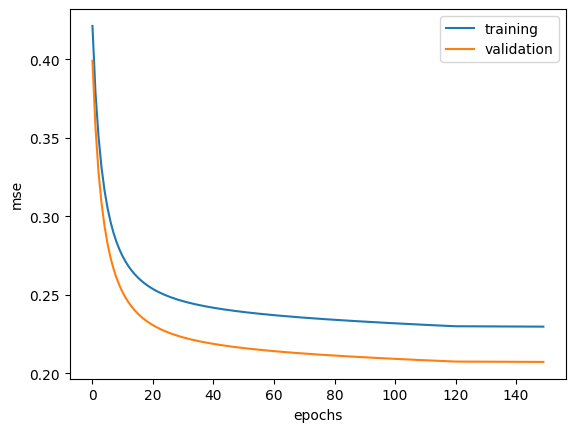

In [23]:
step = 1

plt.plot(losses[::step], label="training")
plt.plot(val_losses[::step],label="validation")
plt.ylabel("mse")
plt.xlabel("epochs")
# plt.yscale("log")
plt.legend()

In [24]:
toSave = newSaveObject(params,CNN_specs)

In [25]:
save_path = "./testing.pickle"

In [16]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

## Loading model

In [17]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [23]:
loaded.forward_pass.apply(loaded.params,X_test[0])

DeviceArray([[[ 0.1777801 ],
              [ 0.19024144],
              [ 0.04433652],
              ...,
              [ 0.08330125],
              [ 0.04082442],
              [-0.12628213]],

             [[ 0.47462916],
              [ 0.55802727],
              [ 0.54111874],
              ...,
              [ 0.43650928],
              [ 0.414063  ],
              [ 0.12940657]],

             [[ 0.34967914],
              [ 0.32608578],
              [ 0.47966298],
              ...,
              [ 0.24396849],
              [ 0.36153558],
              [ 0.3045997 ]],

             ...,

             [[ 0.04370436],
              [ 0.09268199],
              [ 0.0933281 ],
              ...,
              [ 0.08271316],
              [ 0.04360718],
              [ 0.00422545]],

             [[ 0.02303383],
              [ 0.0256235 ],
              [-0.0147077 ],
              ...,
              [ 0.09880973],
              [ 0.05944401],
              [ 0.02394831]],

      